In [1]:
# Wang, Jixin et al. “Pan-Cancer Proteomics Analysis to Identify Tumor-Enriched and Highly Expressed Cell Surface Antigens as Potential Targets for Cancer Therapeutics.”
# Molecular & cellular proteomics : MCP vol. 22,9 (2023)
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10494184/
# https://zenodo.org/records/7991979

In [2]:
# CPTAC_FragPipe_DEG_v01
# Alberto Bejarano 2024

In [3]:
# intensity-based absolute quantification (iBAQ)
# tandem mass tag (TMT) 
# total protein approach (TPA)
# TMT-TPA
# TMT-iBAQ

In [4]:
import time; start = time.time()
from datetime import datetime; print(datetime.now().strftime("%B %d, %Y %H:%M:%S"))

May 26, 2024 16:36:03


In [5]:
import pandas as pd
pd.set_option('display.precision', 2)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)
#        -         -        -        -         -        -         -        -        -         -
from scipy.stats import mannwhitneyu, normaltest
from statannotations.Annotator import Annotator
from statannot import add_stat_annotation
from openpyxl import load_workbook
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import numpy as np
import pyreadr
import re, glob, os
#        -         -        -        -         -        -         -        -        -         -
import warnings; warnings.filterwarnings("ignore") 
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [6]:
filter = "Global"; n = 50
filter = "CancerType"; n = 10

In [7]:
datasetss =[
            ('cptac_brca_tumor_vs_normal_list',  'BRCA'),
            ('cptac_ccrcc_tumor_vs_normal_list', 'ccRCC'),
            ('cptac_coad_tumor_vs_normal_list',  'COAD'),
            ('cptac_gbm_tumor_vs_normal_list',   'GBM'),
            ('cptac_hnscc_tumor_vs_normal_list', 'HNSCC'),
            ('cptac_lscc_tumor_vs_normal_list',  'LSCC'),
            ('cptac_luad_tumor_vs_normal_list',  'LUAD'),
            ('cptac_ov_tumor_vs_normal_list',    'OV'),
            ('cptac_pda_tumor_vs_normal_list',   'PDA'),
            ('cptac_ucec_tumor_vs_normal_list',  'UCEC')
           ]

In [8]:
GenesOfInterest = ['MSLN', 'RAB5A', 'RAB5B', 'ERBB3', 'ERBB2', 'CTLA4']

In [9]:
GenesOfInterest = ['NDUFA4L2', 'NNMT', 'PLIN2', 'SEMA5B', 'FCER1G', 'RHCE', 'RAB42', 'S100A2', 'CA9', 'SLC16A3', 'SCGN', 'FABP7', 'TYROBP', 'ENO2',
                   'CD70', 'HAPLN1', 'PLOD2', 'SPRR4', 'HK2', 'RAD51B', 'FTL', 'AHNAK2', 'SLC2A1', 'ILDR1', 'FAM246A', 'HBE1', 'INTU', 'PFKP', 'KRT74',
                   'FTH1', 'PYGL', 'DEFB112', 'ACKR3', 'FABP6', 'COL23A1', 'SERPINB5', 'NT5DC3', 'SDS', 'L1RE1', 'MMP1', 'SCARB1', 'HAVCR1', 'CTHRC1',
                   'ITGAX', 'PNMA2', 'CYP2J2', 'IKBIP', 'SLC2A3', 'NOL3', 'FCGR3A']

In [10]:
%%time
#        -         -        -        -         -        -         -        -        -         -        -         -
src_path = './data/DEG/'; DEprot_exp = []
#        -         -        -        -         -        -         -        -        -         -        -         -
for file, tumortype in datasetss:
    df = pd.read_csv(src_path + file+'.csv', header=0, sep=',', quotechar='"', on_bad_lines='warn')
    cols = {'ID': 'GeneSymbol'}; df.rename(columns=cols, inplace=True)
    df.drop(['Unnamed: 0'], axis=1, inplace=True)
    df["TumorType"] = tumortype
    df.sort_values(by=['logFC'], ascending=[False], inplace=True); #df=df.head(n)
    df = df[df["GeneSymbol"].isin(GenesOfInterest)]
    try:
        DEprot_exp.append(df)
    except:
        print("An exception occurred")
#        -         -        -        -         -        -         -        -        -         -        -         -        
DEprot_exp_df = pd.concat(DEprot_exp, ignore_index=True)

CPU times: total: 312 ms
Wall time: 336 ms


In [11]:
DEprot_exp_df.sort_values(by=['logFC'], ascending=[False], inplace = True)

In [12]:
#DEprot_exp_df = DEprot_exp_df.head(50)
DEprot_exp_df.head()

,GeneSymbol,logFC,AveExpr,t,P.Value,adj.P.Val,B,TumorType
39,NDUFA4L2,3.60,28.16,31.03,2.68e-77,1.82e-74,165.89,ccRCC
40,NNMT,2.72,29.37,25.04,8.87e-63,7.09e-61,132.55,ccRCC
41,PLIN2,2.60,29.08,21.71,6.99e-54,1.76e-52,112.10,ccRCC
42,SEMA5B,2.46,23.51,23.43,1.49e-58,6.83e-57,122.84,ccRCC
43,FCER1G,2.34,25.68,26.09,1.82e-65,2.03e-63,138.72,ccRCC


In [13]:
GenesOfInterest = DEprot_exp_df.GeneSymbol.tolist()
print(GenesOfInterest[:10])

['NDUFA4L2', 'NNMT', 'PLIN2', 'SEMA5B', 'FCER1G', 'RHCE', 'RAB42', 'S100A2', 'CA9', 'SLC16A3']


In [14]:
len(DEprot_exp_df)

376

In [15]:
#%%time
pivot_df = DEprot_exp_df.pivot(index='TumorType', columns='GeneSymbol', values='logFC')
pivot_df = DEprot_exp_df.pivot(index='GeneSymbol', columns='TumorType', values='logFC')
print("Shape of the dataframe: ", pivot_df.shape, "\n")
pivot_df.head()

Shape of the dataframe:  (50, 10) 



TumorType,BRCA,COAD,GBM,HNSCC,LSCC,LUAD,OV,PDA,UCEC,ccRCC
GeneSymbol,,,,,,,,,,
ACKR3,NaN,NaN,NaN,NaN,1.84,NaN,NaN,NaN,NaN,NaN
AHNAK2,-0.34,-0.95,-0.63,0.12,0.72,0.46,-0.92,0.77,-1.54,1.99
CA9,0.12,0.28,0.29,0.84,0.76,0.63,-0.14,0.18,0.59,2.20
CD70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.11
COL23A1,NaN,NaN,NaN,NaN,0.43,NaN,-0.63,0.39,NaN,1.82


In [16]:
pivot_df.fillna(0.000666, inplace=True)

In [17]:
pivot_df.head()

TumorType,BRCA,COAD,GBM,HNSCC,LSCC,LUAD,OV,PDA,UCEC,ccRCC
GeneSymbol,,,,,,,,,,
ACKR3,6.66e-04,6.66e-04,6.66e-04,6.66e-04,1.84e+00,6.66e-04,6.66e-04,6.66e-04,6.66e-04,6.66e-04
AHNAK2,-3.36e-01,-9.54e-01,-6.25e-01,1.19e-01,7.21e-01,4.58e-01,-9.23e-01,7.71e-01,-1.54e+00,1.99e+00
CA9,1.15e-01,2.83e-01,2.92e-01,8.44e-01,7.56e-01,6.30e-01,-1.41e-01,1.76e-01,5.91e-01,2.20e+00
CD70,6.66e-04,6.66e-04,6.66e-04,6.66e-04,6.66e-04,6.66e-04,6.66e-04,6.66e-04,6.66e-04,2.11e+00
COL23A1,6.66e-04,6.66e-04,6.66e-04,6.66e-04,4.25e-01,6.66e-04,-6.28e-01,3.94e-01,6.66e-04,1.82e+00


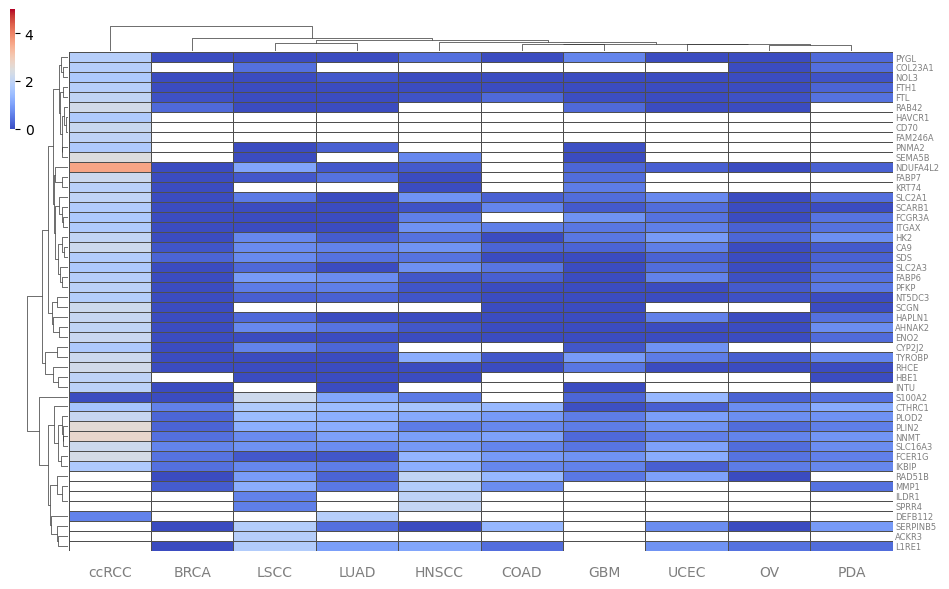

In [68]:
g = sns.clustermap(pivot_df, yticklabels=True, xticklabels=True, metric='euclidean', method='complete',
                    dendrogram_ratio=(.05, .05), cbar_pos=(0, 0.80, 0.005, 0.2), colors_ratio=0.03, mask=pivot_df == 0.000666,
                    linewidth=0.4, linecolor='#4E4E4E', vmin=0, vmax=5, cmap="coolwarm", figsize=(10, 6))
#          -          -          -          -          -          -          -          -          -          -          -  
g.ax_heatmap.tick_params(axis='x', length=0, width=0, colors='green',  pad=10)
g.ax_heatmap.tick_params(axis='y', length=0, width=0, colors='purple', pad=2)
plt.setp(g.ax_heatmap.get_xticklabels(), fontsize=10, color='#7E7E7E', rotation=0)
plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=6,  color='#7E7E7E', rotation=0)
g.ax_heatmap.set_xlabel(''); g.ax_heatmap.set_ylabel('')
#          -          -          -          -          -          -          -          -          -          -          -       
plt.show()

In [ ]:
print("'CPTAC_FragPipe_DEG_Cluster_v01' script run time:", f'{time.time()-start:.0f}', "seconds.")